In [3]:
import numpy as np
import random
import os
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Dataset paths
base_dir = 'augmented_split_dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Parameters
IMG_SIZE = 256
BATCH_SIZE = 32

# Data generators
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True, seed=42)
val_gen = datagen.flow_from_directory(
    val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False)
test_gen = datagen.flow_from_directory(
    test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False)

num_classes = train_gen.num_classes

# CNN model
def build_cnn_model(lr=1e-4, dense_units=128, dropout_rate=0.5):
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Fitness function for DA
def fitness_function(params):
    lr, dense_units, dropout_rate = params
    dense_units = int(dense_units)

    model = build_cnn_model(lr=lr, dense_units=dense_units, dropout_rate=dropout_rate)
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=5,
        callbacks=[early_stop],
        verbose=0
    )
    _, val_acc = model.evaluate(val_gen, verbose=0)
    return -val_acc  # minimize negative accuracy

# Dragonfly Algorithm Implementation
class DragonflyOptimizer:
    def __init__(self, fitness_func, dim, bounds, population_size=6, iterations=10):
        self.fitness_func = fitness_func
        self.dim = dim
        self.bounds = bounds
        self.pop_size = population_size
        self.iterations = iterations

    def initialize(self):
        return np.array([np.random.uniform(low, high, self.pop_size) for low, high in self.bounds]).T

    def optimize(self):
        pop = self.initialize()
        fitness = np.array([self.fitness_func(ind) for ind in pop])
        best_idx = np.argmin(fitness)
        best_pos = pop[best_idx].copy()
        best_score = fitness[best_idx]

        for t in range(self.iterations):
            for i in range(self.pop_size):
                new_pos = pop[i] + np.random.uniform(-0.05, 0.05, self.dim)
                new_pos = np.clip(new_pos, [b[0] for b in self.bounds], [b[1] for b in self.bounds])
                new_fitness = self.fitness_func(new_pos)

                if new_fitness < fitness[i]:
                    pop[i] = new_pos
                    fitness[i] = new_fitness

                    if new_fitness < best_score:
                        best_pos = new_pos.copy()
                        best_score = new_fitness

            print(f"Iteration {t+1}/{self.iterations} | Best Val Accuracy: {-best_score:.4f}")

        return best_pos, -best_score

# Define bounds for lr, dense units, dropout rate
bounds = [
    (1e-5, 1e-3),   # learning rate
    (64, 512),      # dense units
    (0.2, 0.5)      # dropout rate
]

# Run optimization
dim = 3
optimizer = DragonflyOptimizer(fitness_function, dim, bounds, population_size=6, iterations=5)
best_params, best_val_acc = optimizer.optimize()

print("\n✅ Best Parameters Found:")
print("Learning Rate:", best_params[0])
print("Dense Units:", int(best_params[1]))
print("Dropout Rate:", best_params[2])
print("Best Validation Accuracy:", best_val_acc)


Found 21421 images belonging to 10 classes.
Found 4586 images belonging to 10 classes.
Found 4602 images belonging to 10 classes.


/Users/simarkalsi/Projects/leafClassification/leaf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-06-20 00:26:01.215773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Iteration 1/5 | Best Val Accuracy: 0.8803
Iteration 2/5 | Best Val Accuracy: 0.8803
Iteration 3/5 | Best Val Accuracy: 0.8803
Iteration 4/5 | Best Val Accuracy: 0.8803
Iteration 5/5 | Best Val Accuracy: 0.8803

✅ Best Parameters Found:
Learning Rate: 0.0003807947176588889
Dense Units: 90
Dropout Rate: 0.4497327922401265
Best Validation Accuracy: 0.8802878260612488


In [9]:
# Use best parameters from Dragonfly
best_lr = 0.0003807947176588889
best_dense = 90
best_dropout = 0.4497327922401265

# Rebuild the model with optimal parameters
final_model = build_cnn_model(
    lr=best_lr,
    dense_units=best_dense,
    dropout_rate=best_dropout
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Train the final model
history = final_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate on test data
test_loss, test_acc = final_model.evaluate(test_gen, verbose=1)
print(f"\n🎯 Final Test Accuracy after Dragonfly Optimization: {test_acc * 100:.2f}%")


Epoch 1/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 69s 100ms/step - accuracy: 0.5007 - loss: 1.4584 - val_accuracy: 0.7357 - val_loss: 0.7984 - learning_rate: 3.8079e-04
Epoch 2/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 67s 100ms/step - accuracy: 0.7214 - loss: 0.8123 - val_accuracy: 0.8096 - val_loss: 0.5442 - learning_rate: 3.8079e-04
Epoch 3/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 68s 101ms/step - accuracy: 0.7906 - loss: 0.6174 - val_accuracy: 0.6901 - val_loss: 0.9410 - learning_rate: 3.8079e-04
Epoch 4/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 71s 106ms/step - accuracy: 0.8350 - loss: 0.4891 - val_accuracy: 0.8443 - val_loss: 0.4329 - learning_rate: 3.8079e-04
Epoch 5/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 73s 108ms/step - accuracy: 0.8583 - loss: 0.4180 - val_accuracy: 0.8094 - val_loss: 0.5629 - learning_rate: 3.8079e-04
Epoch 6/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 68s 102ms/step - accuracy: 0.8773 - loss: 0.3579 - val_accuracy: 0.8572 - val_loss: 0.4117 - learning_rate: 3.8079e-04
Epoch 7/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 67s 10

In [10]:
final_model.save("dragonfly_optimized_leaf_model.keras")
print("✅ Model saved as 'dragonfly_optimized_leaf_model.keras'")


✅ Model saved as 'dragonfly_optimized_leaf_model.keras'


144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step

✅ Final Test Accuracy: 98.04%

📄 Classification Report:
                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.99      0.98      0.99       476
                        Tomato_Early_blight       0.96      0.97      0.97       445
                         Tomato_Late_blight       0.97      0.96      0.96       467
                           Tomato_Leaf_Mold       0.99      1.00      0.99       447
                  Tomato_Septoria_leaf_spot       0.98      0.97      0.98       468
Tomato_Spider_mites_Two_spotted_spider_mite       0.96      0.98      0.97       467
                        Tomato__Target_Spot       0.98      0.97      0.97       461
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.99      0.99      0.99       482
                Tomato__Tomato_mosaic_virus       0.99      1.00      1.00       427
                             Tomato_healthy       

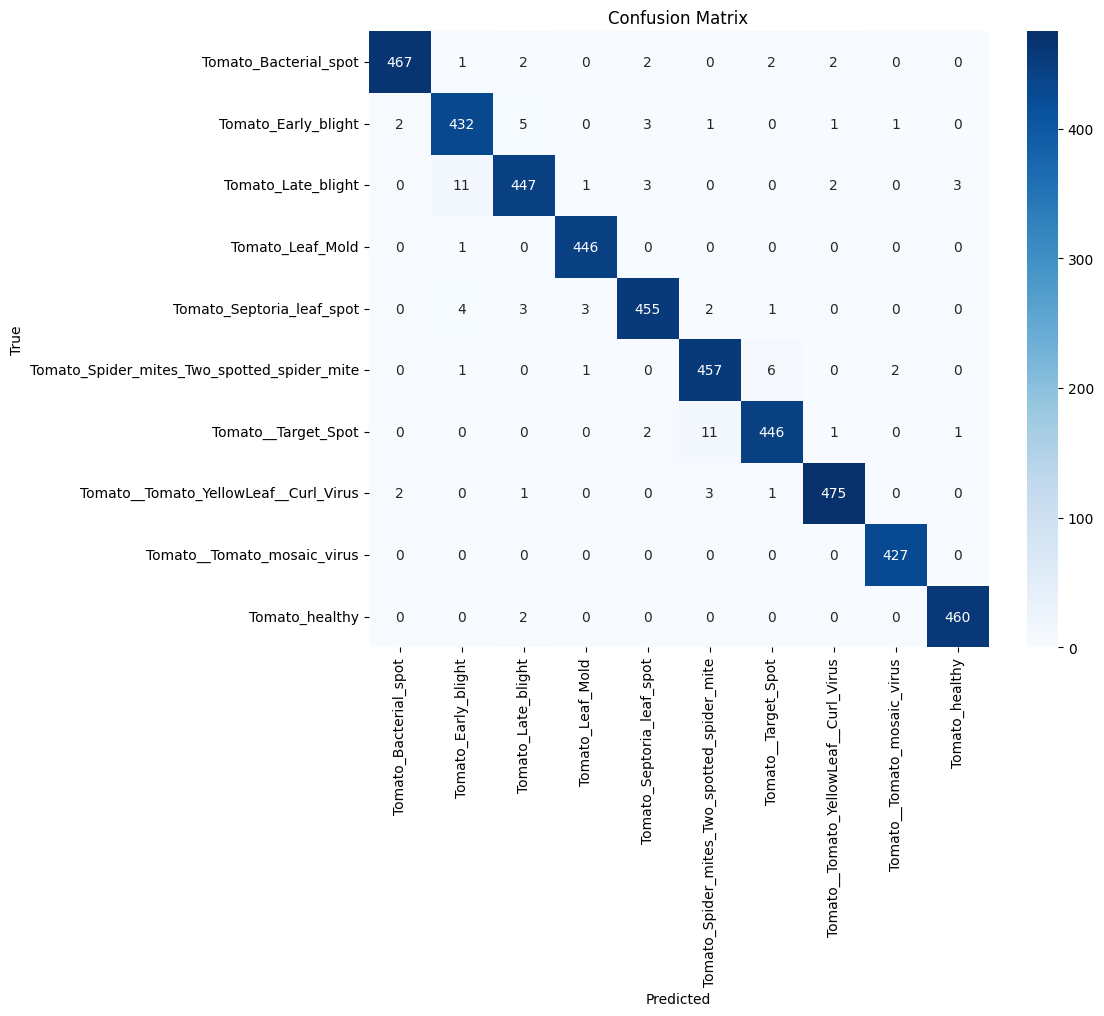

In [11]:
# Get predictions and true labels
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predict classes
pred_probs = final_model.predict(test_gen)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Final Test Accuracy: {acc * 100:.2f}%")

# Classification report
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


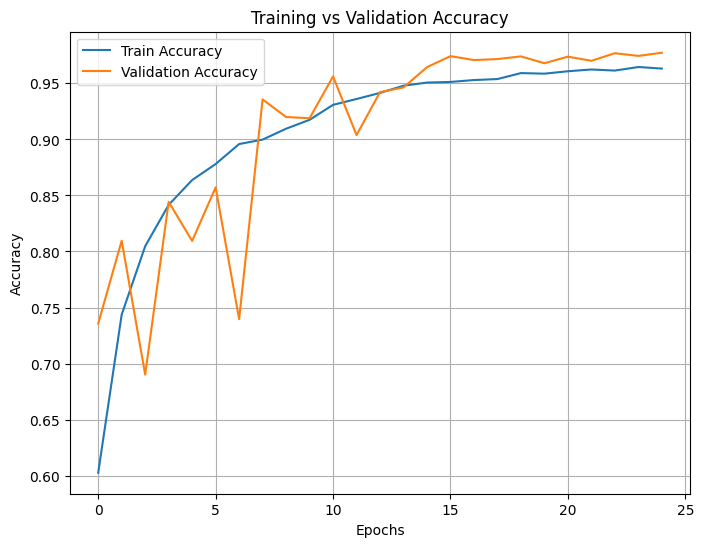

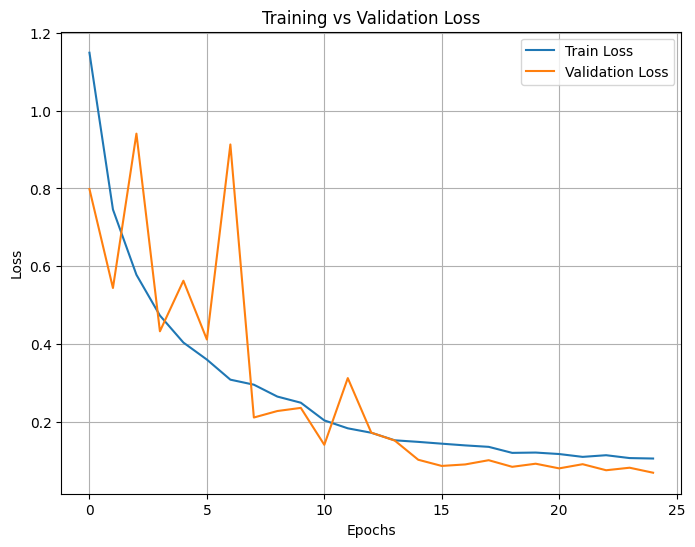

In [12]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
